In [2]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import sys

In [3]:
graph = {}
with open("human_interactome.csv", "r") as f:
    lines = f.read().splitlines() 
    for index in tqdm(range(len(lines))):
        line = lines[index]
        node_names = line.split(",")
        if (len(node_names) != 2):
            continue
        if (graph.get(node_names[0]) is None):
            graph[node_names[0]] = np.array([node_names[1]])
        else:
            graph[node_names[0]] = np.append(graph[node_names[0]], node_names[1])
        if (graph.get(node_names[1]) is None):
            graph[node_names[1]] = np.array([node_names[0]])
        else:
            graph[node_names[1]] = np.append(graph[node_names[1]], node_names[0])
        

100%|██████████| 342353/342353 [00:14<00:00, 24343.50it/s]


In [4]:
# Number of nodes
print("Number of nodes: ", len(graph))

Number of nodes:  21557


In [5]:
# Number of edges
degree = np.array([])
for key in graph:
    degree = np.append(degree, len(graph[key]))
num_edge = np.sum(degree)
print("Number of edges: ", int(num_edge/2))

Number of edges:  342353


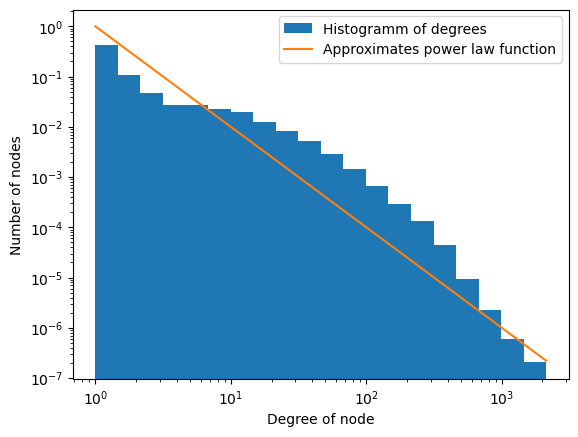

In [6]:
# Plot
# log_degree = pd.Series(np.log10(degree))
# hist, bins, _ = plt.hist(degree)
hist, bins = np.histogram(degree, bins=20)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist(degree, bins=logbins, density=True, label="Histogramm of degrees")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree of node")
plt.ylabel("Number of nodes")
x = np.arange(1, np.max(degree),1)
y = x ** (-2)
plt.plot(x,y,label="Approximates power law function")
plt.legend()
plt.show()

In [7]:
def DFS(node, temp, visited):
    visited.append(node)
    temp.append(node)
    for i in graph[node]:
        if (np.isin(i, visited, assume_unique=True, invert=True)):
            temp, visited = DFS(i, temp, visited)
    return temp, visited

In [14]:
### Find connected components
sys.setrecursionlimit(len(graph))
nodes = list(graph)
visited = []
cc = []
for i in tqdm(range(len(nodes)), desc="Searching for connected components"):
    if (np.isin(nodes[i], visited, assume_unique=True,invert=True)):
        temp = []
        temp, visited = DFS(nodes[i], temp, visited)
        cc.append(temp)

Searching for connected components:   0%|          | 0/21557 [12:47<?, ?it/s]


KeyboardInterrupt: 

In [13]:
len(visited)

2994